In [2]:
import sys
sys.path.append("..")

from dataset.utils import get_cached_data

In [3]:
x, y = get_cached_data("../artifacts")

In [3]:
x.shape

(5000, 500)

In [4]:
import numpy as np

corr_matrix = np.corrcoef(x, rowvar=False)

In [5]:
corr_matrix.shape

(500, 500)

In [6]:
corr_matrix

array([[ 1.00000000e+00,  8.55214083e-01,  7.63481766e-01, ...,
         2.90037436e-03, -1.68930235e-02,  6.84343388e-04],
       [ 8.55214083e-01,  1.00000000e+00,  7.68779586e-01, ...,
        -9.08206626e-03, -1.89422444e-02, -6.22810977e-03],
       [ 7.63481766e-01,  7.68779586e-01,  1.00000000e+00, ...,
         8.95916482e-05, -1.20801339e-02, -2.45980004e-03],
       ...,
       [ 2.90037436e-03, -9.08206626e-03,  8.95916482e-05, ...,
         1.00000000e+00,  8.46094807e-03, -1.51651868e-02],
       [-1.68930235e-02, -1.89422444e-02, -1.20801339e-02, ...,
         8.46094807e-03,  1.00000000e+00, -5.98345020e-03],
       [ 6.84343388e-04, -6.22810977e-03, -2.45980004e-03, ...,
        -1.51651868e-02, -5.98345020e-03,  1.00000000e+00]])

In [12]:
threshold = 0.75
correlated_pairs = np.where(np.abs(corr_matrix) > threshold)
correlated_pairs = [(i, j) for i, j in zip(*correlated_pairs) if i != j and i < j]

In [14]:
features_to_remove = set()
    
for _, j in correlated_pairs:
    features_to_remove.add(j)
    
features_to_remove = list(features_to_remove)
features_to_remove

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [18]:
np.mean(x[:, 105]), np.std(x[:, 105])

(-0.0058915863645113715, 1.0010853571630096)

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x[:, [0]+list(range(10, 500))], y)
mdi_importances = clf.feature_importances_
mdi_importances

array([0.00506913, 0.00157469, 0.0018185 , 0.00184401, 0.00158879,
       0.00168844, 0.00194283, 0.00184904, 0.00204971, 0.00228051,
       0.00198342, 0.00248235, 0.00190347, 0.00171907, 0.00174795,
       0.0020921 , 0.00193895, 0.0015413 , 0.00232409, 0.00231197,
       0.00230522, 0.00222736, 0.00161194, 0.00198775, 0.00167709,
       0.00231126, 0.00206389, 0.00195549, 0.00185636, 0.00197975,
       0.0019509 , 0.0017019 , 0.00158862, 0.00214193, 0.00185287,
       0.00158456, 0.0020212 , 0.00205561, 0.00152266, 0.00170023,
       0.00153007, 0.00182809, 0.00179336, 0.00215265, 0.00189566,
       0.00202465, 0.00158059, 0.0019781 , 0.00190876, 0.00219727,
       0.00229036, 0.00196001, 0.00157776, 0.00189816, 0.00189121,
       0.00220183, 0.00209292, 0.00190208, 0.00178113, 0.0020771 ,
       0.00163383, 0.00242599, 0.00218662, 0.00253494, 0.00168952,
       0.00205786, 0.00217326, 0.00178232, 0.00194642, 0.00217256,
       0.00170358, 0.00219307, 0.00183809, 0.00154031, 0.00200

In [9]:
features = np.argsort(mdi_importances)[::-1]+9
features

NameError: name 'mdi_importances' is not defined

In [27]:
for i in range(10):
    print("Feature", features[i], "importance:", mdi_importances[features[i]-9])

Feature 105 importance: 0.010535882733552297
Feature 102 importance: 0.009977198456265985
Feature 100 importance: 0.009363263769753792
Feature 103 importance: 0.008601968702856053
Feature 101 importance: 0.007800331860220733
Feature 104 importance: 0.006910008114602371
Feature 9 importance: 0.00506912634110211
Feature 498 importance: 0.00260359609400318
Feature 319 importance: 0.0025896686108965567
Feature 129 importance: 0.0025694432828333373


In [12]:
from itertools import combinations

list(combinations([1, 2, 3], 2))

[(1, 2), (1, 3), (2, 3)]

In [10]:
from metrics import calculate_gain
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.svm import SVC

def evaluate_models(x_train, x_test, y_train, y_test, selected_features):
    gains = []
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    gains.append(calculate_gain(y_test, predictions, len(selected_features)))
    #print("Random forest:", calculate_gain(y_test, predictions, len(selected_features)))
    
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(x_train, y_train)
    predictions = qda.predict_proba(x_test)[:, 1]
    gains.append(calculate_gain(y_test, predictions, len(selected_features)))
    #print("QDA:", calculate_gain(y_test, predictions, len(selected_features)))
    
    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.transform(x_test)
    
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(x_train_poly, y_train)
    predictions = qda.predict_proba(x_test_poly)[:, 1]
    gains.append(calculate_gain(y_test, predictions, len(selected_features)))
    #print("QDA Poly:", calculate_gain(y_test, predictions, len(selected_features)))
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(x_train, y_train)
    predictions = lda.predict_proba(x_test)[:, 1]
    gains.append(calculate_gain(y_test, predictions, len(selected_features)))
    #print("LDA:", calculate_gain(y_test, predictions, len(selected_features)))
    
    svm = SVC(probability=True)
    svm.fit(x_train, y_train)
    predictions = svm.predict_proba(x_test)[:, 1]
    gains.append(calculate_gain(y_test, predictions, len(selected_features)))
    #print("SVM:", calculate_gain(y_test, predictions, len(selected_features)))
    
    return gains

In [14]:
from tqdm import tqdm
selected_features = [0, 100, 101, 102, 103, 104, 105]
comb = list(combinations(selected_features, 1)) + list(combinations(selected_features, 2)) + list(combinations(selected_features, 3)) + list(combinations(selected_features, 4)) + list(combinations(selected_features, 5))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
data = []
for i in tqdm(comb):
    x_train_selected = x_train[:, i]
    x_test_selected = x_test[:, i]
    data.append(evaluate_models(x_train_selected, x_test_selected, y_train, y_test, i))

  0%|          | 0/119 [00:00<?, ?it/s]


NameError: name 'RandomForestClassifier' is not defined

In [14]:
data = np.array(data)

In [15]:
np.unravel_index(data.argmax(), data.shape)

(39, 4)

In [16]:
comb[39], data[39, 4]

((0, 102, 105), 7450.000000000001)

In [17]:
import pandas as pd

df = pd.DataFrame(data, columns=["Random Forest", "QDA", "QDA Poly", "LDA", "SVM"])
df.set_index(pd.Series(comb), inplace=True)
df

,Random Forest,QDA,QDA Poly,LDA,SVM
"(0,)",5000.0,6150.0,6150.0,5400.0,6250.0
"(100,)",4850.0,7050.0,7050.0,5900.0,7050.0
"(101,)",4900.0,6400.0,6450.0,5600.0,6350.0
"(102,)",4750.0,6300.0,6300.0,5500.0,6300.0
"(103,)",4900.0,6000.0,6050.0,5450.0,5800.0
...,...,...,...,...,...
"(100, 101, 102, 103, 105)",6050.0,7050.0,7100.0,5050.0,7200.0
"(100, 101, 102, 104, 105)",5450.0,6950.0,6800.0,5450.0,6750.0
"(100, 101, 103, 104, 105)",5650.0,6950.0,6750.0,5150.0,6700.0
"(100, 102, 103, 104, 105)",5400.0,6850.0,6700.0,5100.0,7000.0


In [15]:
from xgboost import XGBClassifier

i = (102, 103, 105)
x_train_selected = x_train[:, i]
x_test_selected = x_test[:, i]

xgb = XGBClassifier(
    objective='binary:logistic', 
    n_estimators=1000, 
    learning_rate=0.1, 
    max_depth=15, 
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(x_train_selected, y_train)
predictions = xgb.predict_proba(x_test_selected)[:, 1]
calculate_gain(y_test, predictions, len(i))

6050.0

In [99]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
x_train_poly = poly.fit_transform(x_train_selected)
x_test_poly = poly.transform(x_test_selected)

xgb.fit(x_train_poly, y_train)
predictions = xgb.predict_proba(x_test_poly)[:, 1]
calculate_gain(y_test, predictions, len(i))

6400.0

In [101]:
svm = SVC(probability=True, kernel="linear")
svm.fit(x_train_selected, y_train)
predictions = svm.predict_proba(x_test_selected)[:, 1]
calculate_gain(y_test, predictions, len(i))

4200.0

In [62]:
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

clf2.fit(x_train_selected, y_train)
predictions = clf2.predict(x_test_selected)
calculate_gain(y_test, predictions, len(selected_features))

5200.0

In [63]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train_selected, y_train)
predictions = qda.predict_proba(x_test_selected)[:, 1]
calculate_gain(y_test, predictions, len(selected_features))

7150.0

In [64]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
x_train_poly = poly.fit_transform(x_train_selected)
x_test_poly = poly.transform(x_test_selected)

qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train_poly, y_train)

predictions = qda.predict_proba(x_test_poly)[:, 1]
calculate_gain(y_test, predictions, len(selected_features))

7200.0

In [66]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(x_train_selected, y_train)
predictions = lda.predict_proba(x_test_selected)[:, 1]
calculate_gain(y_test, predictions, len(selected_features))

5400.0

In [67]:
# SVM
from sklearn.svm import SVC

svm = SVC(probability=True)
svm.fit(x_train_selected, y_train)
predictions = svm.predict_proba(x_test_selected)[:, 1]
calculate_gain(y_test, predictions, len(selected_features))

7000.0

In [61]:
import numpy as np
import pandas as pd
from scipy.interpolate import BSpline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

i = (102, 103, 105)
x_train_selected = x_train[:, i]
x_test_selected = x_test[:, i]

spline_transformer = SplineTransformer(n_knots=2, degree=3)

# Fit and transform the training data
X_train_spline = spline_transformer.fit_transform(x_train_selected)
X_test_spline = spline_transformer.transform(x_test_selected)
model = LinearDiscriminantAnalysis()
model.fit(X_train_spline, y_train)
predictions = model.predict_proba(X_test_spline)[:, 1]
calculate_gain(y_test, predictions, len(i))

7100.0

In [19]:
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
x_train_poly = poly.fit_transform(x_train_selected)
x_test_poly = poly.transform(x_test_selected)

qda = LinearDiscriminantAnalysis()
qda.fit(x_train_poly, y_train)
predictions = qda.predict_proba(x_test_poly)[:, 1]
calculate_gain(y_test, predictions, len(i))

7450.000000000001

In [18]:
svm = SVC(probability=True, kernel="poly", degree=2)
svm.fit(x_train_selected, y_train)
predictions = svm.predict_proba(x_test_selected)[:, 1]
calculate_gain(y_test, predictions, len(selected_features))

6700.000000000001

In [21]:
# add interactions
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
x_train_poly = poly.fit_transform(x_train_selected)
x_test_poly = poly.transform(x_test_selected)
x_train_poly.shape

(4000, 9)

In [22]:
# Naive bayes gaussion
from sklearn.naive_bayes import GaussianNB

m = GaussianNB()
m.fit(x_train_selected, y_train)
predictions = m.predict_proba(x_test_selected)[:, 1]
calculate_gain(y_test, predictions, len(selected_features))

6700.000000000001

In [23]:
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
x_train_poly = poly.fit_transform(x_train_selected)
x_test_poly = poly.transform(x_test_selected)

m.fit(x_train_poly, y_train)
predictions = m.predict_proba(x_test_poly)[:, 1]
calculate_gain(y_test, predictions, len(selected_features))

6450.0

In [7]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

kd = KernelDensity(kernel="gaussian", bandwidth="silverman")


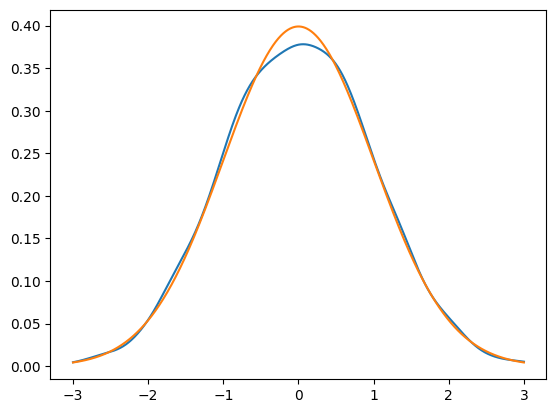

In [8]:
import numpy as np

def normal_density(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu)/sigma)**2)

def compare_to_normal(index):
    kd.fit(x[:, index].reshape(-1, 1))
    x_data = np.linspace(-3, 3, 1000)
    y_hat = np.exp(kd.score_samples(x_data.reshape(-1, 1)))
    y_data = normal_density(x_data, 0, 1)
    
    return x_data, [y_hat, y_data]

x1, (y1, y2) = compare_to_normal(100)
plt.plot(x1, y1)
plt.plot(x1, y2)
plt.show()

In [9]:
import wandb
from project_config import config

important_features = [0, 100, 101, 102, 103, 104, 105]
selected_features = [102, 103, 105]

x_multiline, ys_multiline = compare_to_normal(0)
ys_multiline = ys_multiline[1:]
keys = ["standard normal distribution"]

for i in important_features:
    _, (y_current, _) = compare_to_normal(i)
    ys_multiline.append(y_current)
    keys.append(f"Feature {i+1}")
    
colors = np.concatenate([((y == 1)*255).reshape(-1, 1), ((y == 0)*255).reshape(-1, 1), np.zeros((y.shape[0], 1))], axis=1)
point_cloud = np.concatenate([x[:, selected_features], colors], axis=1)


In [11]:
with wandb.init(project=config.project, entity=config.entity, job_type="correlation"):
    wandb.log({
        "comparison_with_normal": wandb.plot.line_series(
            xs=x_multiline,
            ys=ys_multiline,
            keys=keys,
            title="Comparison of densities with standard normal distribution"
        ),
        "feature_point_cloud": wandb.Object3D(point_cloud, caption="103, 104, 105 features point cloud"),
    })

wandb: Currently logged in as: simonexc (dl-mini). Use `wandb login --relogin` to force relogin
